# Khun Poker - 2 Jugadores

## Imports

In [ ]:
from games.kuhn.kuhn import KuhnPoker
from agents.counterfactual_regret import CounterFactualRegret
from agents.ismcts import InformationSetMCTS
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, Optional, Tuple

## Definitions

In [2]:
game = KuhnPoker(initial_player=0) # Set the initial player to 0 in all games

In [37]:
def play(game, agents, niter=5000):
    total_rewards = {agent: 0. for agent in game.agents}
    cum_rewards = {agent: [] for agent in game.agents}
    time_taken = {agent: [] for agent in game.agents}
    winners = []

    for i in range(niter):
        if (i+1) % 100 == 0:
            print(f'Iteration {i+1}/{niter}')
        game.reset()
        turn = 0
        while not game.done():
            start_time = time.time()
            a = agents[game.agent_selection].action()
            time_taken[game.agent_selection].append(time.time() - start_time)
            game.step(action=a)
            turn += 1
        for agent in game.agents:
            total_rewards[agent] += game.rewards[agent]
            cum_rewards[agent].append(total_rewards[agent])
        # Determine the winner (reward > 0)
        winners.append(max(game.agents, key=lambda agent: game.rewards[agent]))

    print('Average rewards:', dict(map(lambda agent: (agent, total_rewards[agent]/niter), game.agents)))
    print('Teoretical rewards: ', {game.agents[0]: np.round(-1/18, 3), game.agents[1]: np.round(1/18, 3)})

    return cum_rewards, time_taken, winners

def plot_time_results(time_taken, training_time_dict):
    # Separate training time and action calculation time for CFR agent
    action_time = {agent: sum(times) for agent, times in time_taken.items()}

    # Calculate total time (training + action calculation)
    total_time = {agent: action_time[agent] + training_time_dict[agent] for agent in action_time.keys()}

    # Calculate average move time (excluding training time)
    avg_time = {agent: np.mean(times) for agent, times in time_taken.items()}

    # Plot total time with stacked bars
    plt.figure(figsize=(10, 6))
    bar_width = 0.6
    agents = list(total_time.keys())
    action_times = [action_time[agent] for agent in agents]
    training_times = [training_time_dict[agent] for agent in agents]

    plt.bar(agents, action_times, bar_width, label="Action Calculation Time", color='blue', alpha=0.7)
    plt.bar(agents, training_times, bar_width, bottom=action_times, label="Training Time", color='orange', alpha=0.7)

    plt.title("Total Time Taken by Each Agent")
    plt.xlabel("Agent")
    plt.ylabel("Total Time (seconds)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot average move time
    plt.figure(figsize=(10, 6))
    plt.bar(avg_time.keys(), avg_time.values(), color='green', alpha=0.7)
    plt.title("Average Time Taken per Action by Each Agent")
    plt.xlabel("Agent")
    plt.ylabel("Average Time per Action (seconds)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_rewards(game, niter, cum_rewards):
    theorical_rewards = {game.agents[0]: np.round(-1/18, 3), game.agents[1]: np.round(1/18, 3)}
    colors = ['blue', 'orange']  # Define colors for agents

    # Plot cumulative rewards
    plt.figure(figsize=(10, 6))
    for agent, rewards in cum_rewards.items():
        agent_index = game.agents.index(agent)  # Get the index of the agent
        color = colors[agent_index]  # Assign color based on agent index
        normalized_rewards = [reward / niter for reward in rewards]
        plt.plot(range(1, niter + 1), normalized_rewards, label=f"Average Rewards - {agent}", color=color)
        plt.hlines(y=theorical_rewards[agent], xmin=0, xmax=niter + 1, linestyle='--', label=f'Theoretical Reward {agent}', color=color)

    plt.title("Average Rewards Over Games")
    plt.xlabel("Games")
    plt.ylabel("Average Rewards")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_winners(game, niter, cum_rewards, winners):
    # Count wins for each agent
    win_counts = {agent: winners.count(agent) for agent in game.agents}
    loss_counts = {agent: niter - win_counts[agent] for agent in game.agents}

    # Plot wins and losses
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    agents = list(win_counts.keys())
    wins = [win_counts[agent] for agent in agents]
    losses = [loss_counts[agent] for agent in agents]

    x = np.arange(len(agents))
    plt.bar(x, wins, bar_width, label="Wins", color='green', alpha=0.7)
    plt.bar(x + bar_width, losses, bar_width, label="Losses", color='red', alpha=0.7)

    plt.title("Wins and Losses by Each Agent")
    plt.xlabel("Agent")
    plt.ylabel("Number of Plays")
    plt.xticks(x + bar_width / 2, agents)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

    reward_per_play_0 = np.diff(cum_rewards['agent_0']) 
    reward_per_play_1 = np.diff(cum_rewards['agent_1'])

    # Calculate amount of times reward was 2, 1 -1 and -2
    reward_counts_0 = {
        '2': np.sum(reward_per_play_0 == 2),
        '1': np.sum(reward_per_play_0 == 1),
        # '-1': np.sum(reward_per_play_0 == -1),
        # '-2': np.sum(reward_per_play_0 == -2)
    }

    reward_counts_1 = {
        '2': np.sum(reward_per_play_1 == 2),
        '1': np.sum(reward_per_play_1 == 1),
        # '-1': np.sum(reward_per_play_1 == -1),
        # '-2': np.sum(reward_per_play_1 == -2)
    }

    # Make a plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(len(reward_counts_0))
    plt.bar(x - bar_width/2, reward_counts_0.values(), bar_width, label='Agent 0', color='blue', alpha=0.7)
    plt.bar(x + bar_width/2, reward_counts_1.values(), bar_width, label='Agent 1', color='orange', alpha=0.7)
    plt.title("Reward Counts per Play")
    plt.xlabel("Reward Value")
    plt.ylabel("Count")
    plt.xticks(x, reward_counts_0.keys())
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def play_n_iterations_and_plot(game, agents, niter=5000, iterations=10):
    cum_rewards_per_iteration = []
    for i in range(iterations):
        print(f"\n--- Iteración {i+1}/{iterations} ---")
        cum_rewards, _, _ = play(game, agents, niter)
        cum_rewards_per_iteration.append(cum_rewards)

    theorical_rewards = {game.agents[0]: np.round(-1/18, 3), game.agents[1]: np.round(1/18, 3)}

    # Separate figures for each agent with all iteration plots
    for agent in game.agents:
        plt.figure(figsize=(10, 6))
        for i, cum_rewards in enumerate(cum_rewards_per_iteration):
            plt.plot(range(1, niter + 1), [cum_rewards[agent][j] / niter for j in range(niter)], alpha=0.6)
        plt.hlines(y=theorical_rewards[agent], xmin=0, xmax=niter + 1, color='red', linestyle='--', label=f'Theoretical Reward {agent}')
        plt.title(f"Mean Rewards Over Cumulative Iterations - {agent}")
        plt.xlabel("Iteration")
        plt.ylabel("Mean Rewards")
        plt.legend()
        plt.grid(True)
        plt.show()


    # Plot the last cumulative reward value for every iteration in separate figures for each agent
    for agent in game.agents:
        plt.figure(figsize=(10, 6))
        for i, cum_rewards in enumerate(cum_rewards_per_iteration):
            # Extract the last cumulative reward value for the current iteration
            last_reward = cum_rewards[agent][-1]/ niter  # Normalize by number of iterations
            plt.bar(i + 1, last_reward, alpha=0.7)
        plt.hlines(y=theorical_rewards[agent], xmin=0, xmax=iterations + 1, color='red', linestyle='--', label=f'Theoretical Reward {agent}')
        plt.title(f"Mean reward per Iteration ({niter} games) - {agent}")
        plt.xlabel("Iteration")
        plt.ylabel("Mean Reward")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_strategy_evolution(strategy_history: Dict[str, list], iteration_history: list, 
                            info_set_keys: Optional[list] = None, 
                            action_names: Dict[int, str] = {0: 'Pass', 1: 'Bet'}) -> None:
    """
    Plot the evolution of strategies over training iterations.
    """
    if action_names is None:
        action_names = {0: 'Pass', 1: 'Bet'}
    
    if info_set_keys is None:
        info_set_keys = list(set(key.split('_action_')[0] for key in strategy_history.keys()))
        info_set_keys = sorted(info_set_keys)
    
    n_plots = len(info_set_keys)    
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,8))
    axes_flat = axes.flatten() if n_plots > 1 else [axes]
    
    for i, info_set_key in enumerate(info_set_keys):
        ax = axes_flat[i]
        max_actions = max(int(key.split('_action_')[1]) + 1 for key in strategy_history.keys() if key.startswith(f"{info_set_key}_action_"))
        
        for action_idx in range(max_actions):
            strategy_key = f"{info_set_key}_action_{action_idx}"
            if strategy_key in strategy_history:
                x_data = iteration_history[:len(strategy_history[strategy_key])]
                y_data = strategy_history[strategy_key]
                action_name = action_names.get(action_idx, f"Action {action_idx}")
                ax.plot(x_data, y_data, label=action_name, linewidth=2)
        
        ax.set_title(f"Strategy Evolution: {info_set_key}")
        ax.set_xlabel("Training Iteration")
        ax.set_ylabel("Action Probability")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    
    for i in range(n_plots, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_convergence_analysis(strategy_history: Dict[str, list], iteration_history: list, 
                               info_set_key: str, 
                               action_names: Dict[int, str] = {0: 'Pass', 1: 'Bet'},
                               theoretical_values: Optional[Dict[int, Tuple[float, float]]] = None) -> None:
    """
    Plot convergence analysis for a specific information set, with theoretical values as areas.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    available_actions = sorted(int(key.split('_action_')[1]) for key in strategy_history.keys() if key.startswith(f"{info_set_key}_action_"))
    
    colors = ['orange','blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    for action_idx in available_actions:
        strategy_key = f"{info_set_key}_action_{action_idx}"
        if strategy_key in strategy_history:
            x_data = iteration_history[:len(strategy_history[strategy_key])]
            y_data = strategy_history[strategy_key]
            action_name = action_names.get(action_idx, f"Action {action_idx}")
            ax1.plot(x_data, y_data, label=f"Learned {action_name}", linewidth=2)
            
            # Plot theoretical values as areas
            if theoretical_values and action_idx in theoretical_values:
                lower_bound, upper_bound = theoretical_values[action_idx]
                ax1.fill_between(x_data, lower_bound, upper_bound, color=colors[action_idx % len(colors)], alpha=0.2, label=f"Theoretical Range {action_name}")

    ax1.set_title(f"Strategy Convergence: {info_set_key}")
    ax1.set_xlabel("Training Iteration")
    ax1.set_ylabel("Action Probability")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    if theoretical_values:
        for action_idx in available_actions:
            strategy_key = f"{info_set_key}_action_{action_idx}"
            if strategy_key in strategy_history and action_idx in theoretical_values:
                errors = [abs(prob - (theoretical_values[action_idx][0] + theoretical_values[action_idx][1]) / 2) for prob in strategy_history[strategy_key]]
                x_data = iteration_history[:len(errors)]
                action_name = action_names.get(action_idx, f"Action {action_idx}")
                ax2.plot(x_data, errors, label=f"Error {action_name}", linewidth=2)
        
        ax2.set_title("Convergence Error")
        ax2.set_xlabel("Training Iteration")
        ax2.set_ylabel("Absolute Error")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
    else:
        ax2.text(0.5, 0.5, 'No theoretical values\nprovided', transform=ax2.transAxes, ha='center', va='center')
        ax2.set_title("Theoretical Comparison")
    
    plt.tight_layout()
    plt.show()


## CFR vs CFR

### Chequear la política aprendida

#### Entrenar 1 agente 10 veces

In [4]:
num_runs = 10
training_iterations = 10000
all_policies = []

print(f"Ejecutando {num_runs} sesiones de entrenamiento de {training_iterations} iteraciones cada una...")

for i in range(num_runs):
    print(f"\n--- Iniciando Ejecución {i+1}/{num_runs} ---")
    game.reset()
    agent_name = game.agents[0]
    check_policy_agent = CounterFactualRegret(
        game=game, 
        agent=agent_name, 
        seed=24 
    )

    check_policy_agent.train(training_iterations)

    run_policies = {}
    
    # Extraer la política final del diccionario de nodos del agente
    policy = OrderedDict(
        (n, check_policy_agent.node_dict[n].policy()) 
        for n in sorted(check_policy_agent.node_dict.keys())
    )
    print(policy)
    
    run_policies[agent_name] = policy
    all_policies.append(run_policies)
    print(f"Ejecución {i+1} completada. Políticas almacenadas.")

Ejecutando 10 sesiones de entrenamiento de 10000 iteraciones cada una...

--- Iniciando Ejecución 1/10 ---
OrderedDict([('0', array([0.87431769, 0.12568231])), ('0b', array([9.99847654e-01, 1.52346130e-04])), ('0p', array([0.62747266, 0.37252734])), ('0pb', array([9.99914081e-01, 8.59186459e-05])), ('1', array([0.99899044, 0.00100956])), ('1b', array([0.62724999, 0.37275001])), ('1p', array([0.99724686, 0.00275314])), ('1pb', array([0.56139744, 0.43860256])), ('2', array([0.66341594, 0.33658406])), ('2b', array([1.44969556e-04, 9.99855030e-01])), ('2p', array([7.24847782e-04, 9.99275152e-01])), ('2pb', array([1.14435923e-04, 9.99885564e-01]))])
Ejecución 1 completada. Políticas almacenadas.

--- Iniciando Ejecución 2/10 ---
OrderedDict([('0', array([0.74446624, 0.25553376])), ('0b', array([9.99851146e-01, 1.48853826e-04])), ('0p', array([0.70880435, 0.29119565])), ('0pb', array([9.99897619e-01, 1.02381421e-04])), ('1', array([0.99585883, 0.00414117])), ('1b', array([0.6213509, 0.378649

#### Comparar contra los valores teóricos

Los valores teóricos se calculan solo para los casos en los que existe un valor teórico para el Information Set. Existen casos como '2p' en el que el valor teórico es diferente según si el oponente tiene una Q o una J y por lo tanto no se puede calcular un valor teórico único.

In [5]:
def get_theoretical_values(alpha):
    """
    Devuelve los valores teóricos de las políticas para el Kuhn Poker dado un alpha.
    """
    return {
        '0': np.array([1 - alpha, alpha]),          # J: Bet alpha
        '1': np.array([1.0, 0.0]),                  # Q: Pass
        '2': np.array([max(0, 1 - 3*alpha), min(1, 3*alpha)]), # K: Bet 3*alpha (con clipping)
        '1pb': np.array([2/3-alpha, alpha+1/3]),                # Q, p-b: Fold (Pass)
        '2pb': np.array([0.0, 1.0]),                 # K, p-b: Call (Bet)
    }

In [6]:
# Calculate the average policy across all runs
average_policies = {}

info_sets = all_policies[0][agent_name].keys()
average_policies[agent_name] = {
    info_set: np.mean([run[agent_name][info_set] for run in all_policies], axis=0)
    for info_set in info_sets
}

print("\n--- Verificando Políticas Promedio contra Valores Teóricos ---")
all_match = True
tolerance = 0.05

for agent_name, avg_policy in average_policies.items():
    print(f"\nVerificando Agente: {agent_name}")

    # Get alpha from the agent's policy of InfoSet '0', probability of Bet
    alpha = avg_policy['0'][1]
    print(f"  -> Alpha extraído: {alpha:.4f}")
    theoretical_policy = get_theoretical_values(alpha)

    for info_set, avg_actions in avg_policy.items():
        if info_set in theoretical_policy:
            theoretic_actions = theoretical_policy[info_set]
            if np.allclose(avg_actions, theoretic_actions, atol=tolerance):
                print(f"  InfoSet '{info_set}': OK.       Promedio: {np.round(avg_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")
            else:
                all_match = False
                print(f"  InfoSet '{info_set}': FALLO.    Promedio: {np.round(avg_actions, 3)}, Teórico: {np.round(theoretic_actions, 3)}")

if all_match:
    print("\n¡Éxito! Todas las políticas promedio coinciden con los valores teóricos dentro de la tolerancia.")
else:
    print("\nAlgunas políticas promedio no coinciden con los valores teóricos.")


--- Verificando Políticas Promedio contra Valores Teóricos ---

Verificando Agente: agent_0
  -> Alpha extraído: 0.2180
  InfoSet '0': OK.       Promedio: [0.782 0.218], Teórico: [0.782 0.218]
  InfoSet '1': OK.       Promedio: [0.997 0.003], Teórico: [1. 0.]
  InfoSet '1pb': OK.       Promedio: [0.43 0.57], Teórico: [0.449 0.551]
  InfoSet '2': OK.       Promedio: [0.318 0.682], Teórico: [0.346 0.654]
  InfoSet '2pb': OK.       Promedio: [0.001 0.999], Teórico: [0. 1.]

¡Éxito! Todas las políticas promedio coinciden con los valores teóricos dentro de la tolerancia.


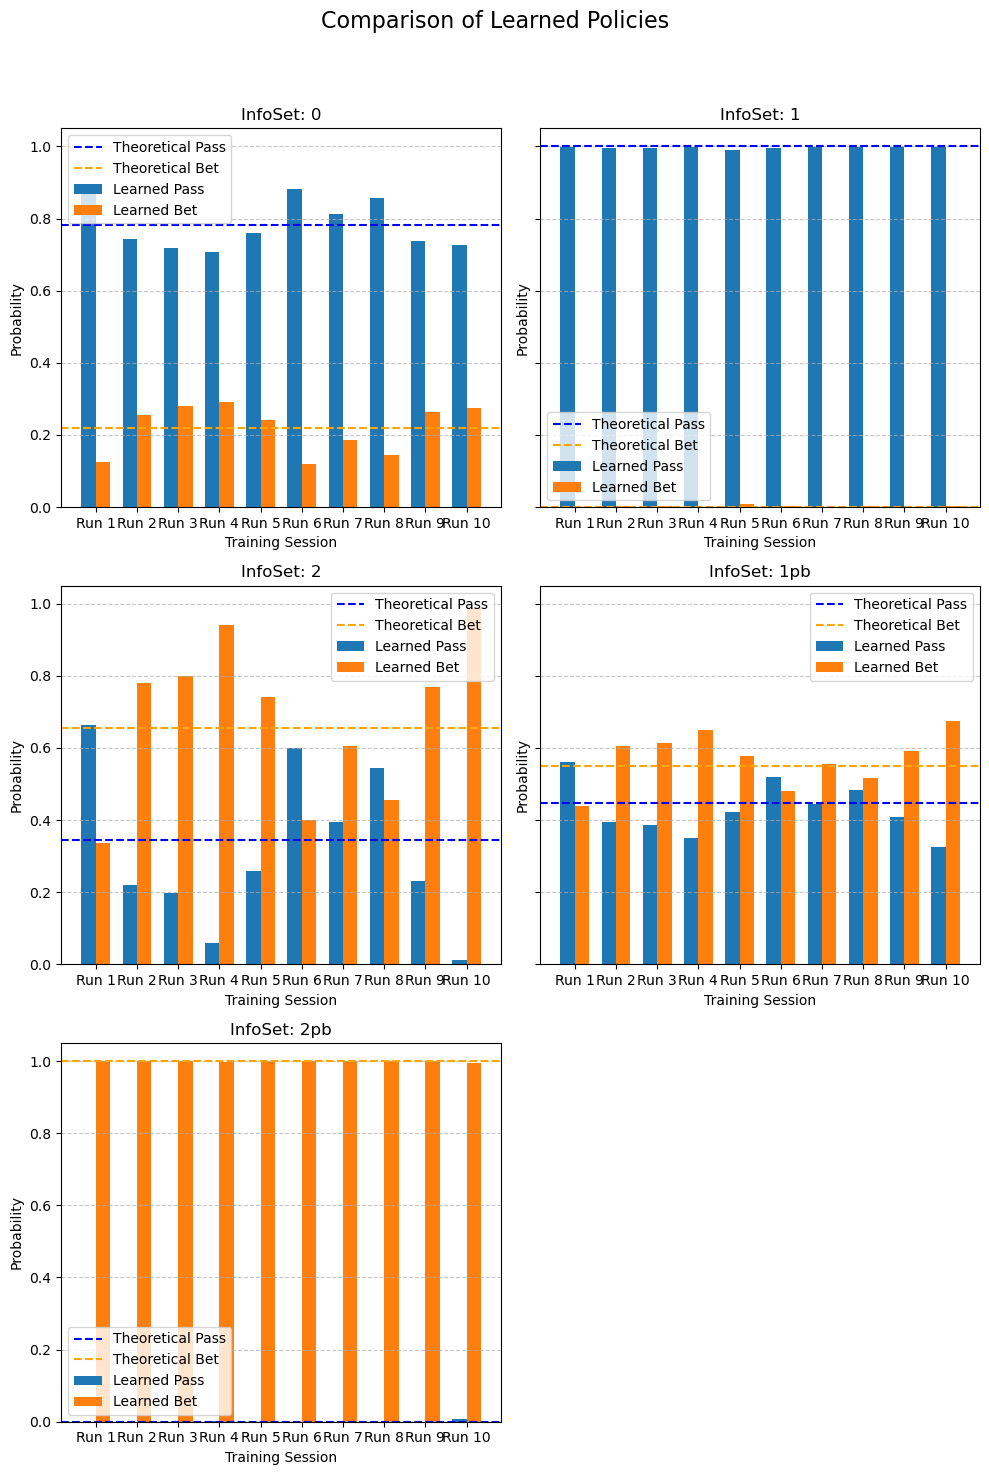

In [11]:
#alpha = 1/3  # For reference we use a fixed alpha value
alpha = average_policies[agent_name]['0'][1]  # Extract alpha from the average policy of InfoSet '0'
theoretical_policy = get_theoretical_values(alpha)


info_sets = list(theoretical_policy.keys())
num_info_sets = len(info_sets)
nrows = 3
ncols = (num_info_sets + 1) // 3  # Ensure all info sets fit into 2 rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), sharey=True)
fig.suptitle(f"Comparison of Learned Policies", fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

for idx, info_set in enumerate(info_sets):
    ax = axes[idx]
    theoretic_actions = theoretical_policy[info_set]
    learned_values = [run[agent_name][info_set] for run in all_policies if info_set in run[agent_name]]

    if not learned_values:
        ax.set_title(f"InfoSet: {info_set}")
        ax.text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.axis('off')
        continue

    x = np.arange(len(learned_values))
    width = 0.35

    # Plot learned values
    for action_idx, action_name in enumerate(['Pass', 'Bet']):
        ax.bar(x + width * action_idx, [values[action_idx] for values in learned_values], width, label=f'Learned {action_name}')

    # Plot theoretical values
    colors = ['blue', 'orange']
    for action_idx, action_name in enumerate(['Pass', 'Bet']):
        ax.axhline(y=theoretic_actions[action_idx], color=colors[action_idx], linestyle='--', label=f'Theoretical {action_name}')

    # Add labels and legend
    ax.set_title(f"InfoSet: {info_set}")
    ax.set_xlabel("Training Session")
    ax.set_ylabel("Probability")
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels([f"Run {i+1}" for i in range(len(learned_values))])
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hide unused subplots
for idx in range(len(info_sets), len(axes)):
    axes[idx].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Análisis del entrenamiento

In [18]:
agent_classes = [CounterFactualRegret, CounterFactualRegret]
my_agents = {}
game.reset()
for i, agent in enumerate(game.agents):
    my_agents[agent] = agent_classes[i](
        game=game, 
        agent=agent, 
        track_frequency=1,
        seed=42,
    )

In [19]:
for agent in game.agents:
    print('Training agent ' + agent)
    my_agents[agent].train(10000)
    print('Agent ' + agent + ' policies:')
    print(OrderedDict(map(lambda n: (n, my_agents[agent].node_dict[n].policy()), sorted(my_agents[agent].node_dict.keys()))))
    print('')

Training agent agent_0
Agent agent_0 policies:
OrderedDict([('0', array([0.79557251, 0.20442749])), ('0b', array([9.99697153e-01, 3.02846760e-04])), ('0p', array([0.68540577, 0.31459423])), ('0pb', array([9.99909048e-01, 9.09519862e-05])), ('1', array([0.99887246, 0.00112754])), ('1b', array([0.63748953, 0.36251047])), ('1p', array([0.99791667, 0.00208333])), ('1pb', array([0.38660376, 0.61339624])), ('2', array([0.20544325, 0.79455675])), ('2b', array([1.52532032e-04, 9.99847468e-01])), ('2p', array([7.62660159e-04, 9.99237340e-01])), ('2pb', array([3.61414037e-04, 9.99638586e-01]))])

Training agent agent_1
Agent agent_1 policies:
OrderedDict([('0', array([0.82909599, 0.17090401])), ('0b', array([9.99850746e-01, 1.49253731e-04])), ('0p', array([0.65826517, 0.34173483])), ('0pb', array([9.99910604e-01, 8.93961576e-05])), ('1', array([0.99822585, 0.00177415])), ('1b', array([0.65349992, 0.34650008])), ('1p', array([9.99378882e-01, 6.21118012e-04])), ('1pb', array([0.4939893, 0.5060107]

#### Evolución de la política durante el entrenamiento

**Agente 0**

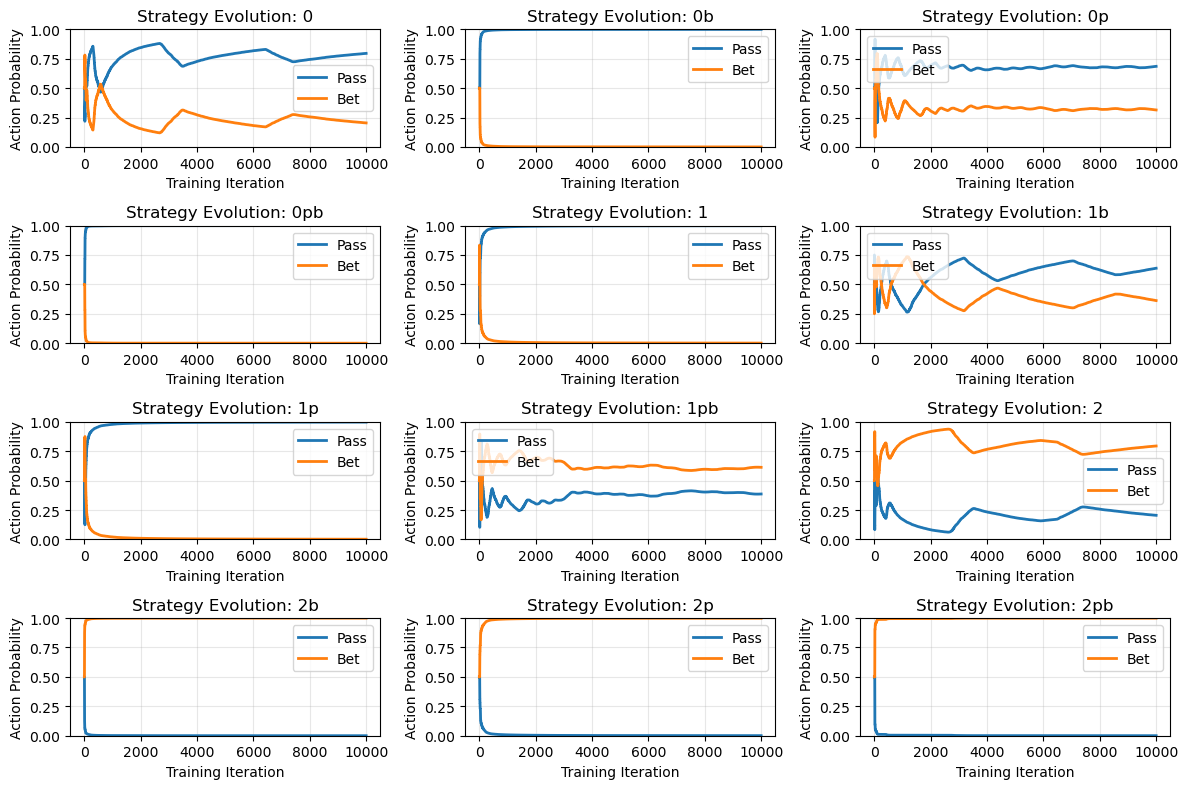

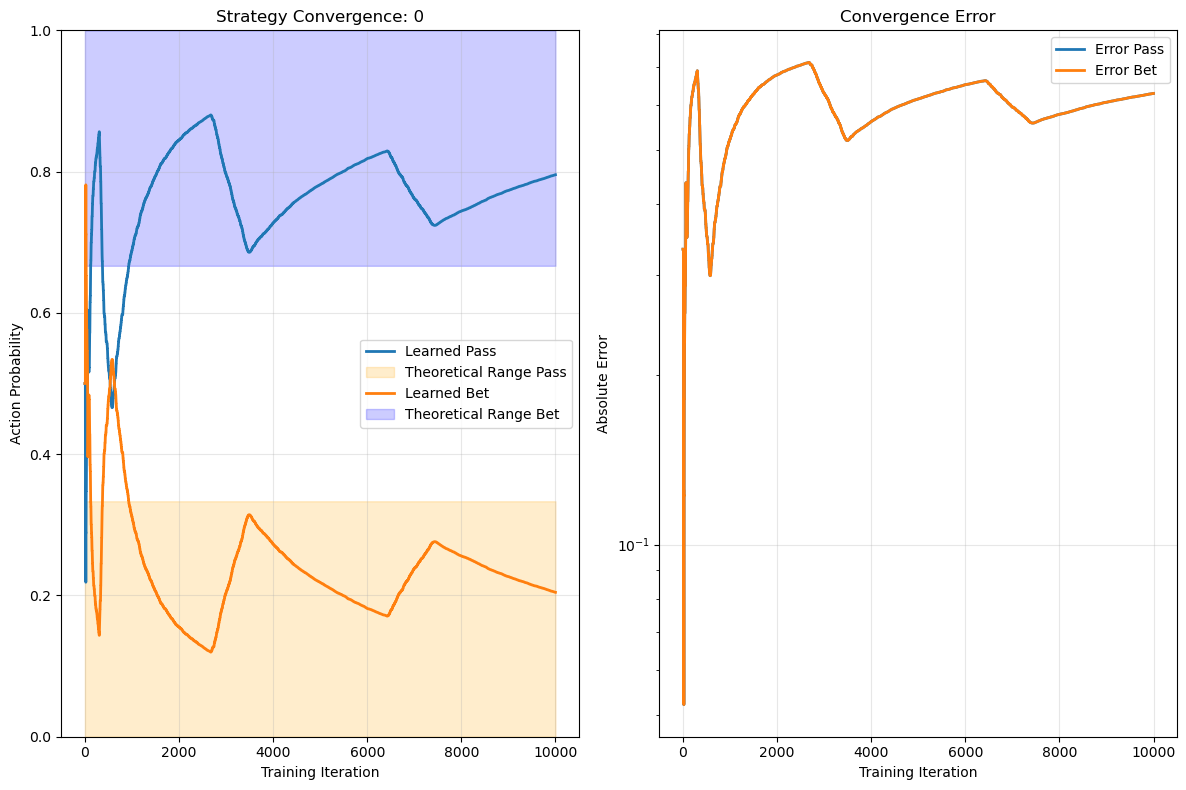

In [20]:
theoretical_JX_bet = 1/3

strategy_history = my_agents['agent_0'].strategy_history
iteration_history = my_agents['agent_0'].iteration_history

plot_strategy_evolution(strategy_history, iteration_history)

theoretical_values = {
    0: (0, theoretical_JX_bet),          # Pass: Range from 0 to 1/3
    1: (2/3, 1)                          # Bet: Range from 2/3 to 1
}
plot_convergence_analysis(strategy_history, iteration_history, 
                          info_set_key='0', theoretical_values=theoretical_values)

**Agente 1**

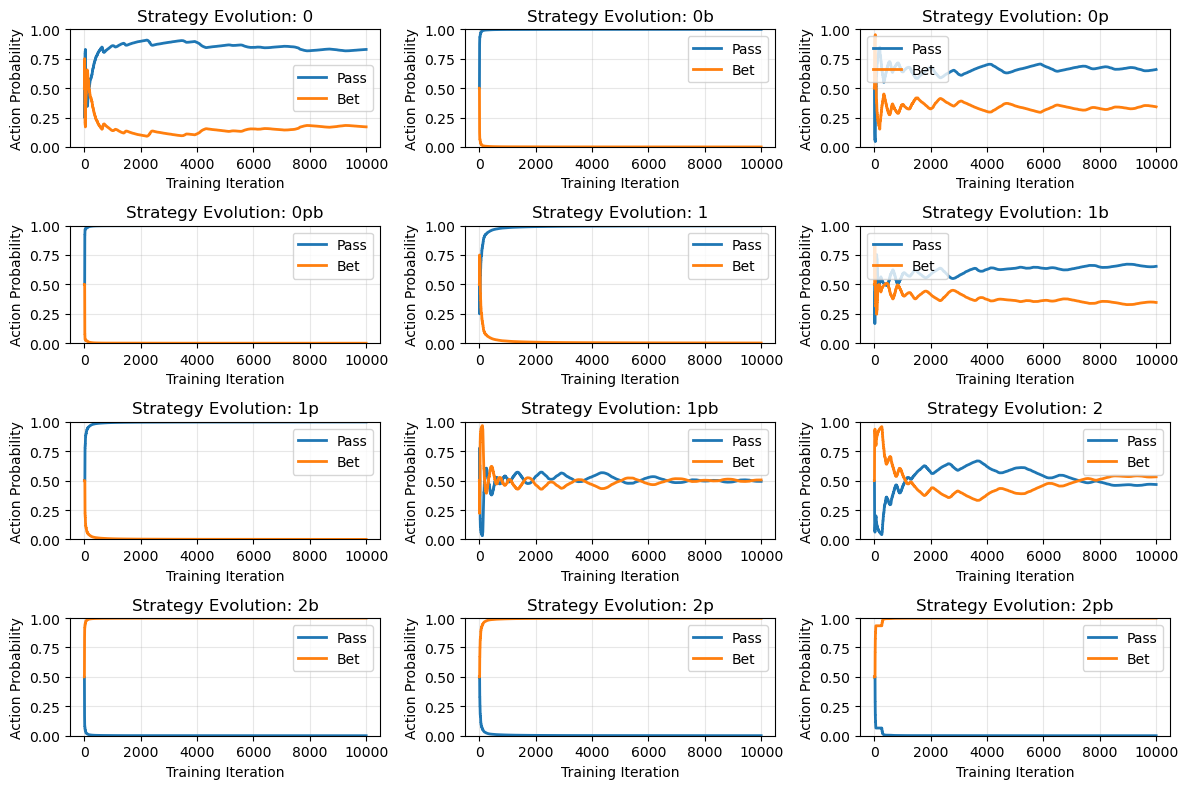

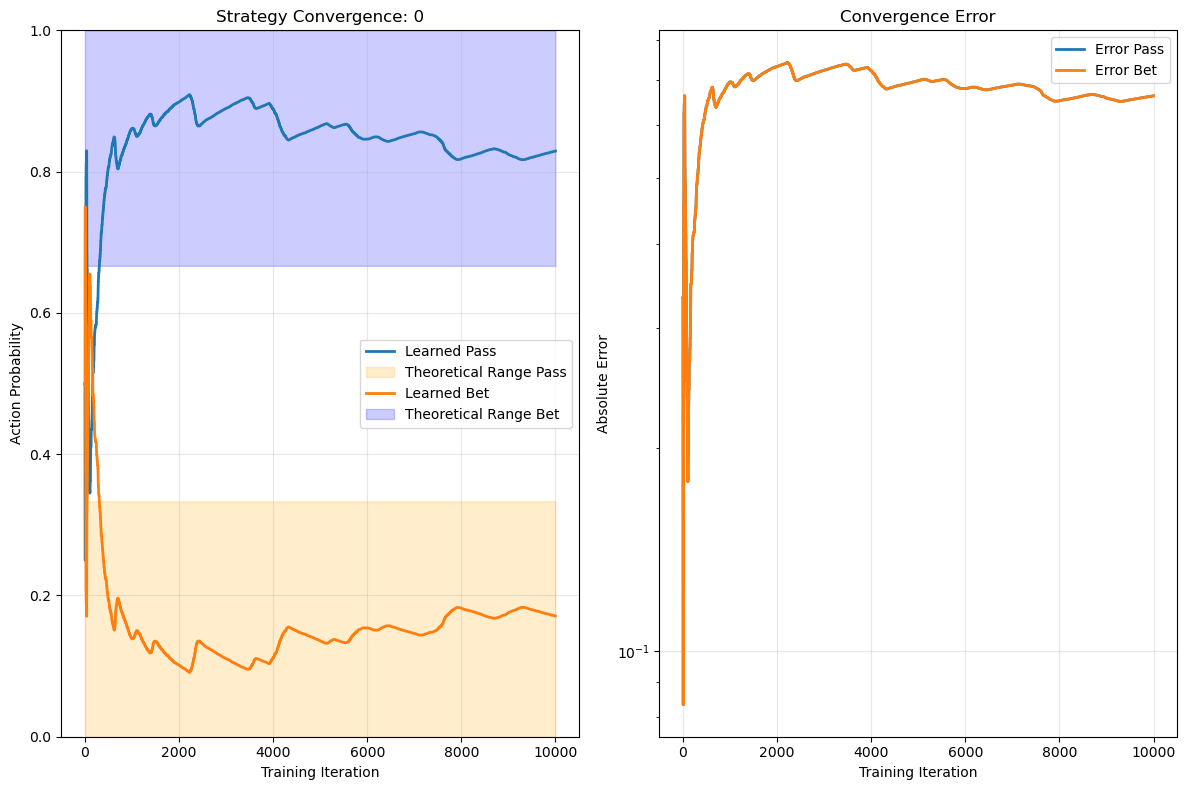

In [21]:
theoretical_JX_bet = 1/3

strategy_history = my_agents['agent_1'].strategy_history
iteration_history = my_agents['agent_1'].iteration_history

plot_strategy_evolution(strategy_history, iteration_history)

theoretical_values = {
    0: (0, theoretical_JX_bet),          # Pass: Range from 0 to 1/3
    1: (2/3, 1)                          # Bet: Range from 2/3 to 1
}
plot_convergence_analysis(strategy_history, iteration_history, 
                          info_set_key='0', theoretical_values=theoretical_values)

#### Partidas CFR vs CFR

Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Iteration 5000/5000
Average r

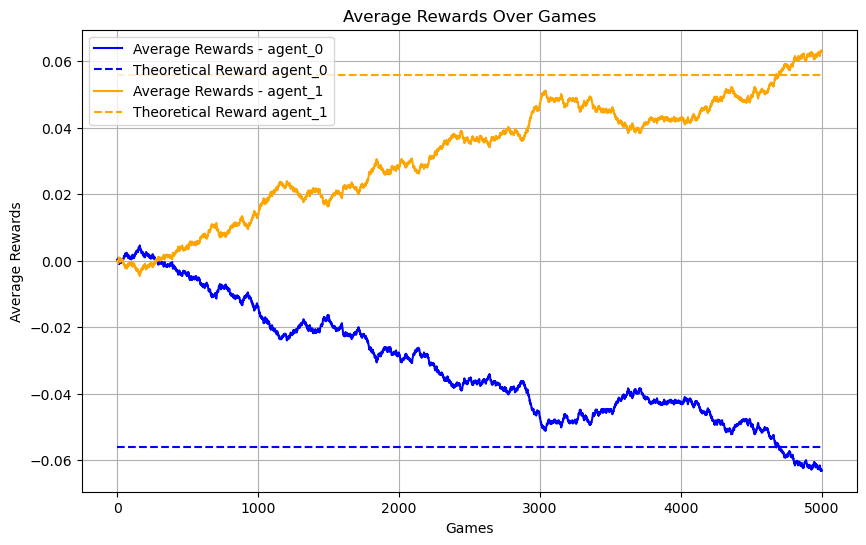

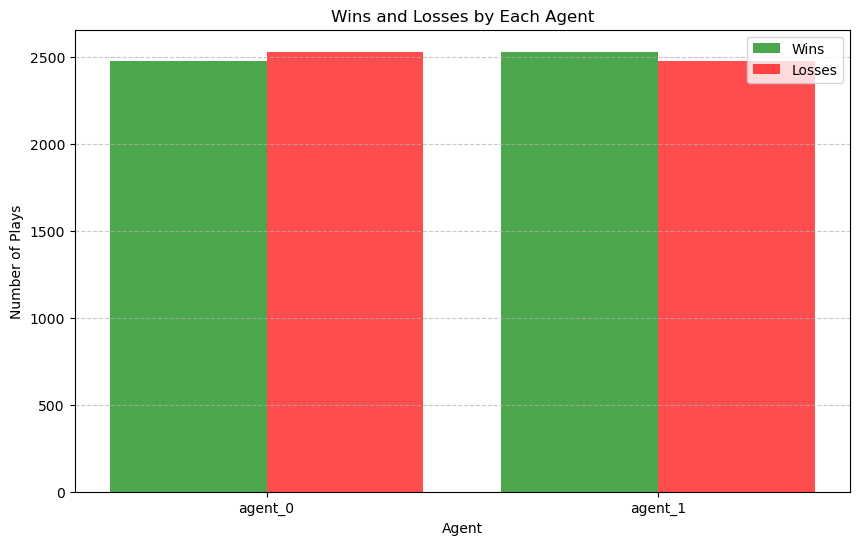

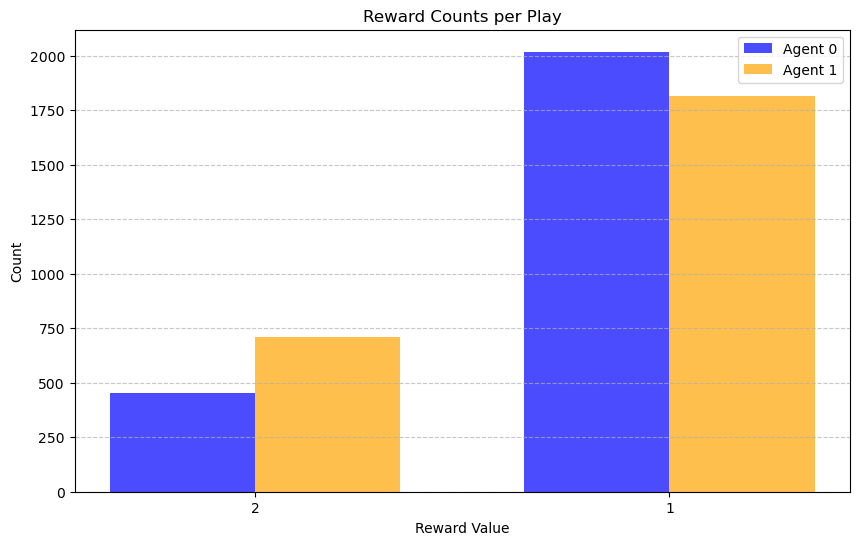

In [30]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, my_agents, niter)
training_time_dict = {agent: 0 for agent in game.agents}
#plot_time_results(time_taken, training_time_dict=training_time_dict)
plot_rewards(game, niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)


--- Iteración 1/10 ---
Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Itera

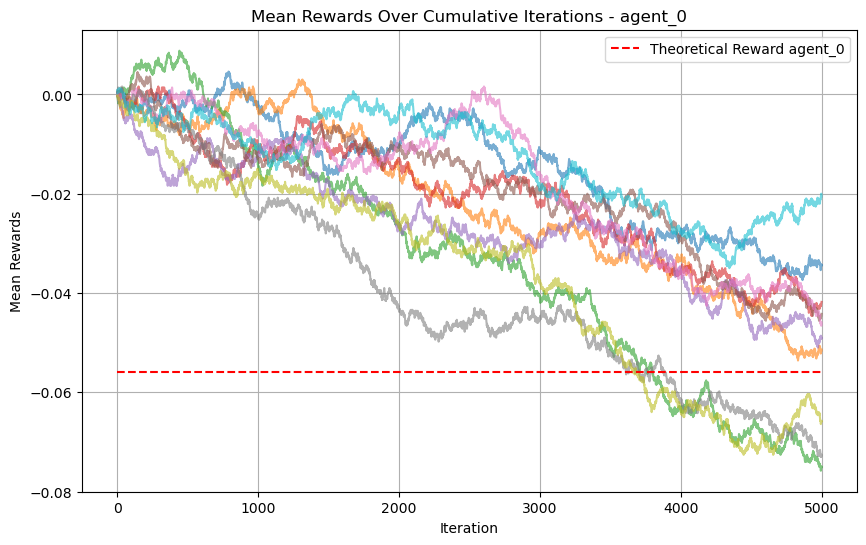

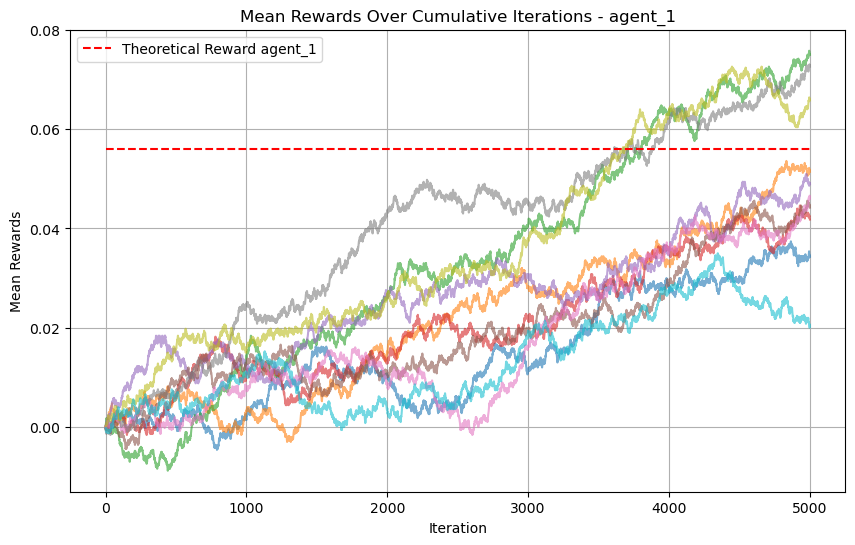

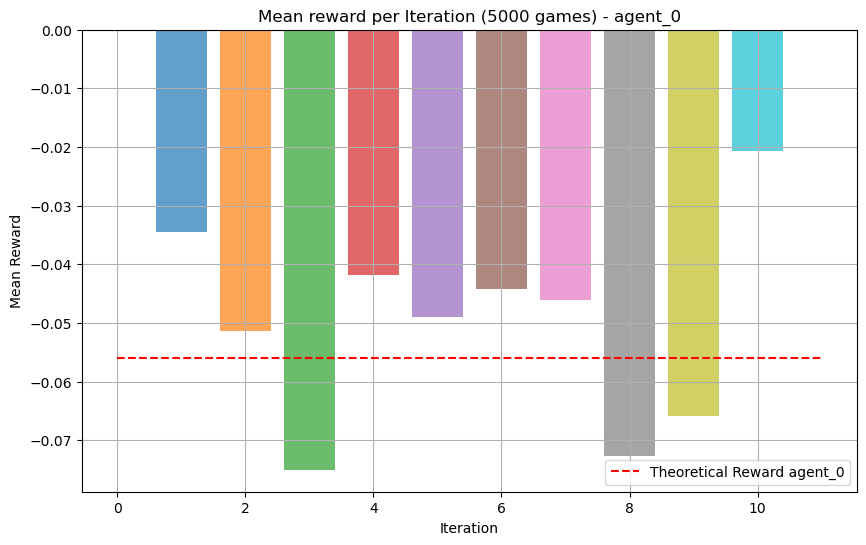

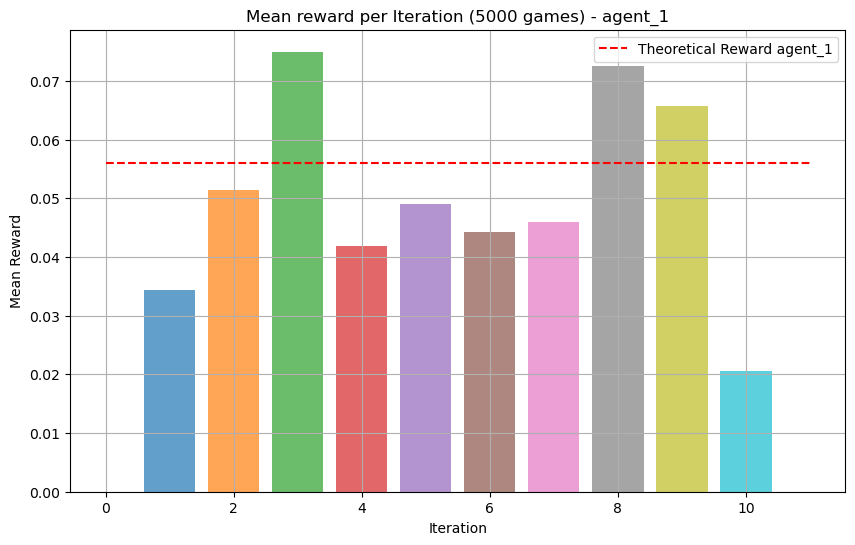

In [38]:
play_n_iterations_and_plot(game, my_agents, niter=5000, iterations=10)

## CFR vs ISMCTS

### Fast ISMCTS

In [39]:
# Reutilizamos uno de los agentes entrenados para CFR vs CFR
cfr_ismcts_agents_fast = {'agent_0': CounterFactualRegret(
    game=game,
    agent='agent_0',
    seed=42,
    track_frequency=1,
), 'agent_1': InformationSetMCTS(
    game=game,
    agent='agent_1',
    rollouts=1,
    simulations=1
)}

In [40]:
# Train the CFR agent and store the time
start_time = time.time()
cfr_ismcts_agents_fast['agent_0'].train(10000)
training_time = time.time() - start_time
print(f"Tiempo de entrenamiento del agente CFR: {training_time:.2f} segundos")


Tiempo de entrenamiento del agente CFR: 25.89 segundos


Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Iteration 5000/5000
Average r

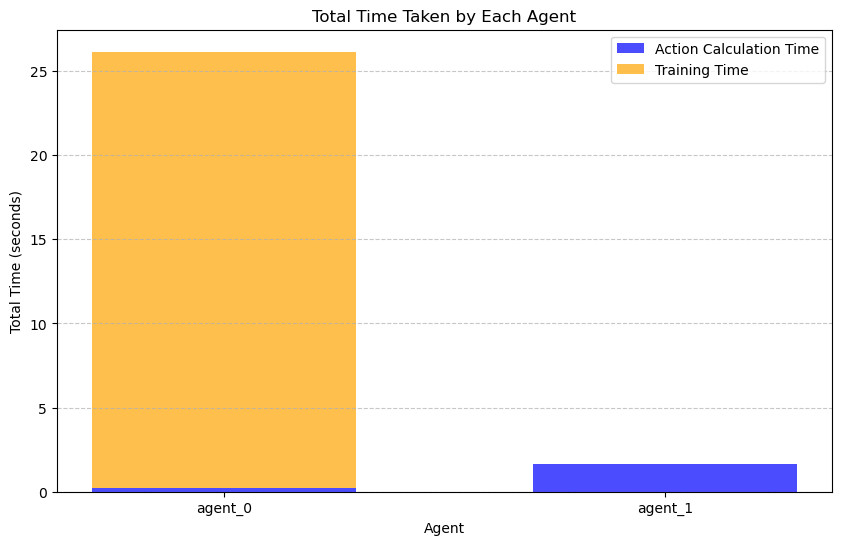

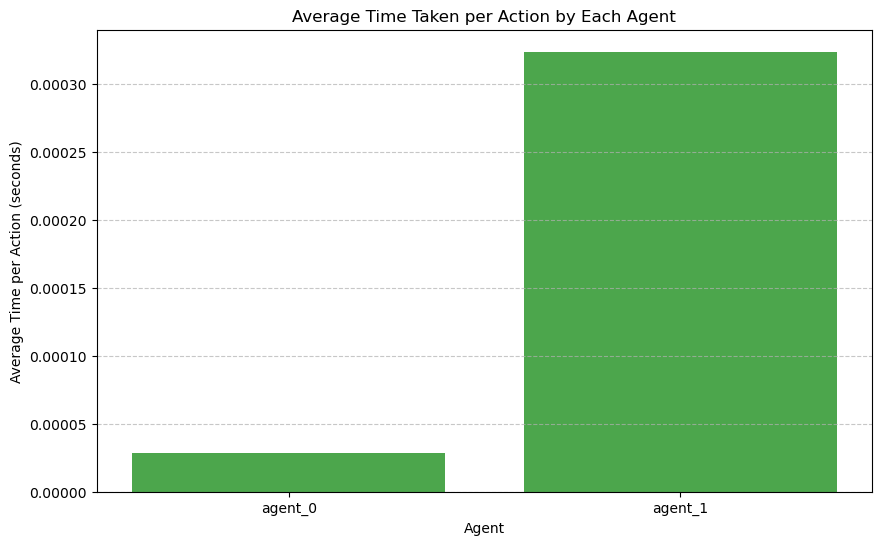

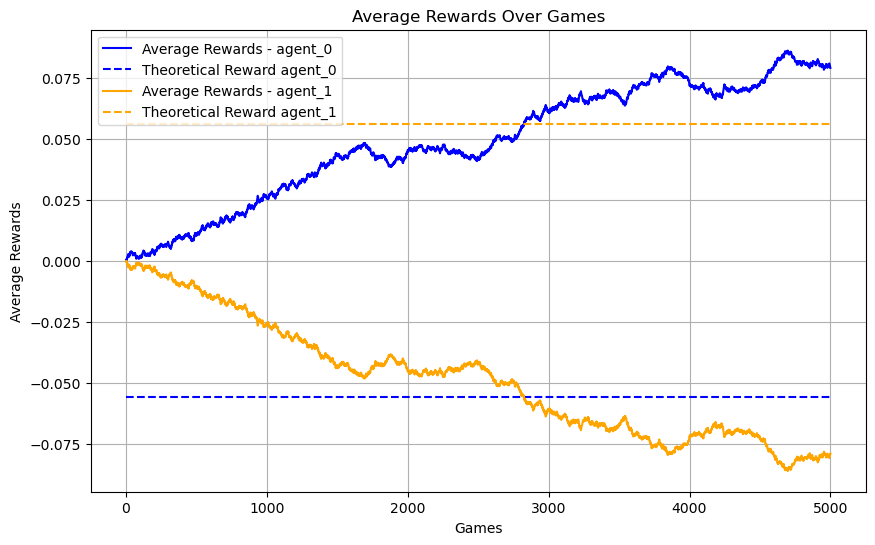

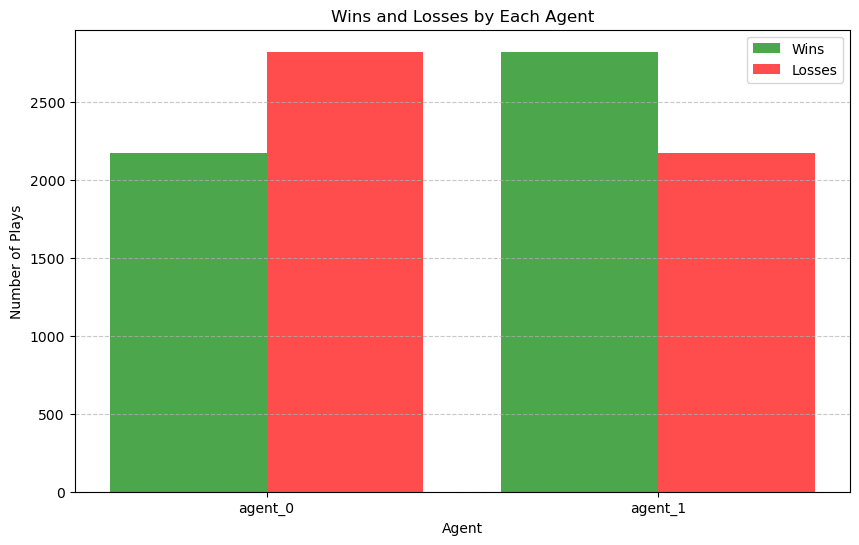

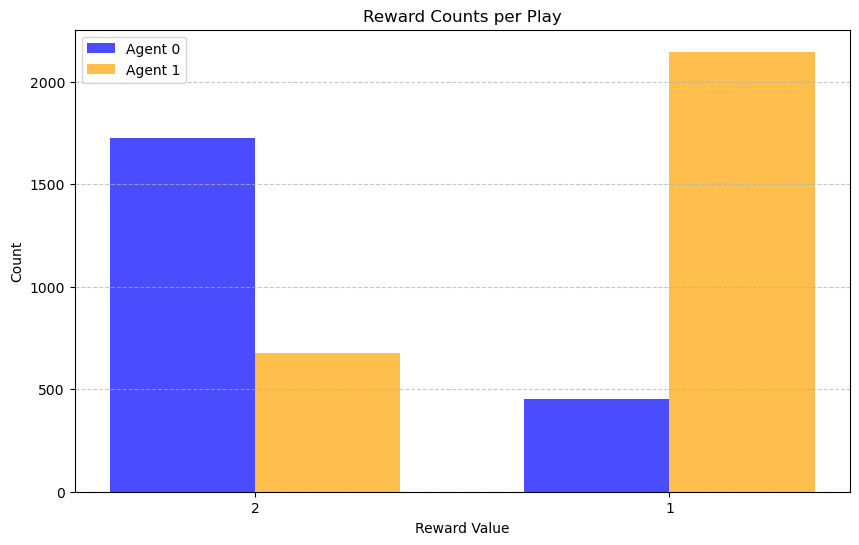

In [41]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, cfr_ismcts_agents_fast, niter)
training_time_dict = {agent: training_time if agent == 'agent_0' else 0 for agent in game.agents}
plot_time_results(time_taken, training_time_dict=training_time_dict)
plot_rewards(game,niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)


--- Iteración 1/10 ---
Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Itera

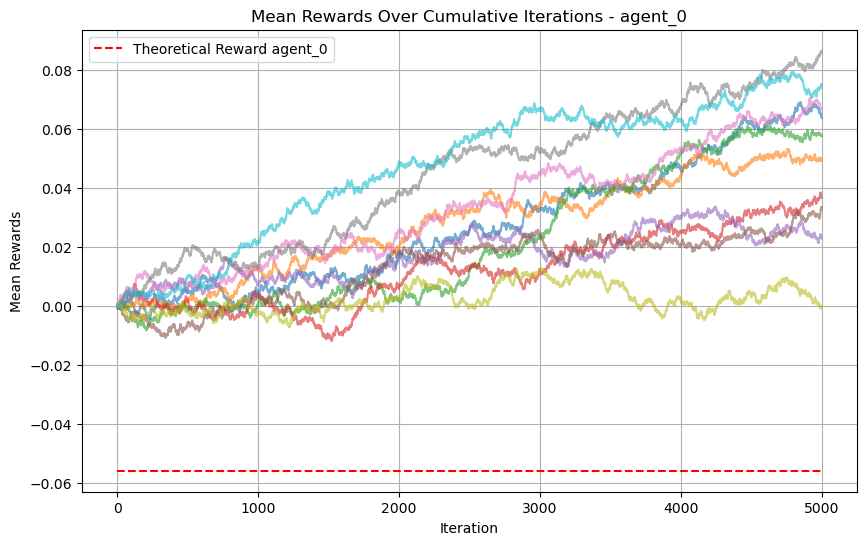

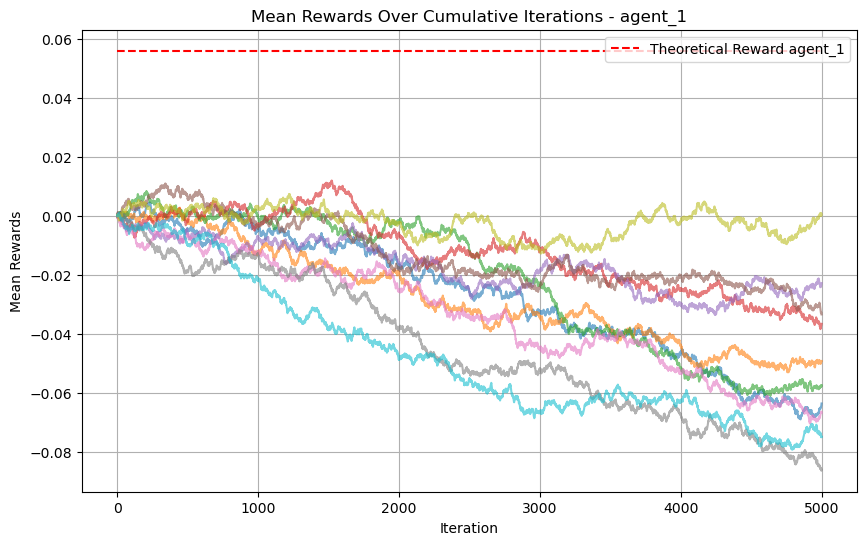

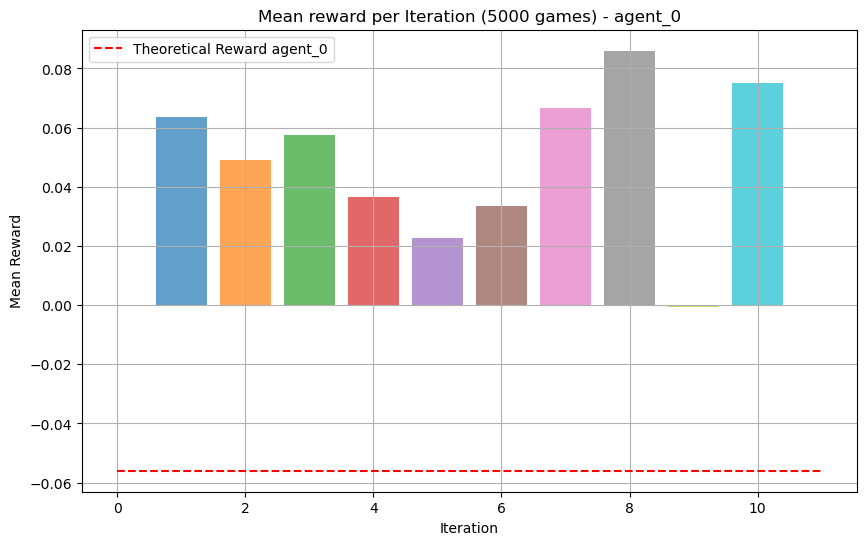

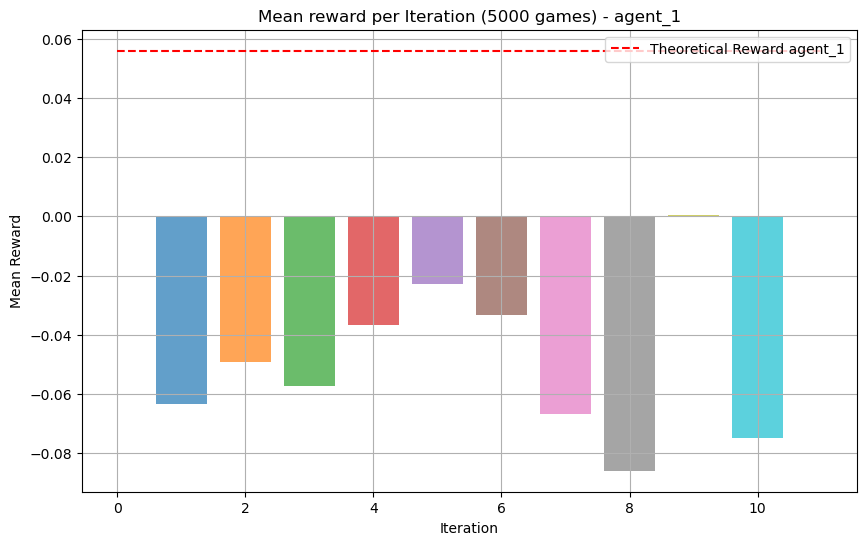

In [42]:
play_n_iterations_and_plot(game, cfr_ismcts_agents_fast, niter=5000, iterations=10)

### Normal ISMCTS

In [57]:
cfr_ismcts_agents = {'agent_0': CounterFactualRegret(
    game=game,
    agent='agent_0',
    seed=42,
    track_frequency=1,
), 'agent_1': InformationSetMCTS(
    game=game,
    agent='agent_1',
    rollouts=5,
    simulations=15
)}

In [58]:
# Train the CFR agent and store the time
start_time = time.time()
cfr_ismcts_agents['agent_0'].train(10000)
training_time = time.time() - start_time
print(f"Tiempo de entrenamiento del agente CFR: {training_time:.2f} segundos")


Tiempo de entrenamiento del agente CFR: 25.64 segundos


Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Iteration 5000/5000
Average r

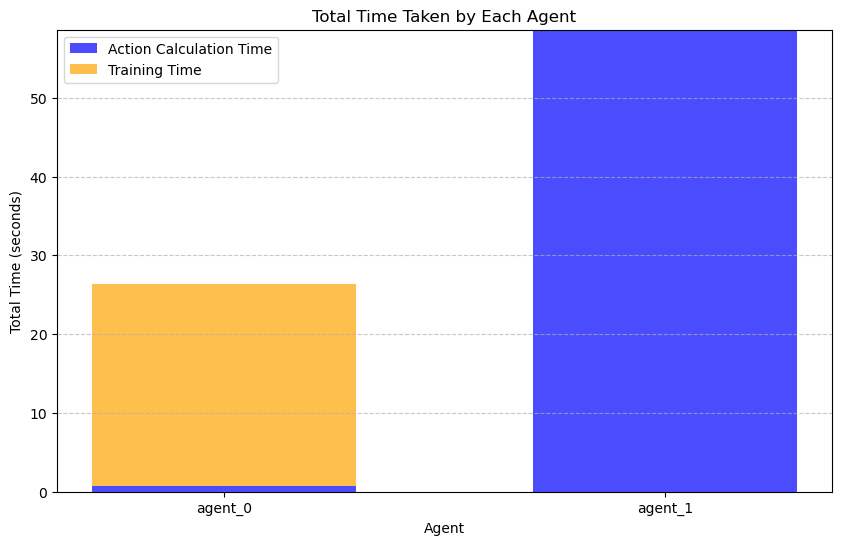

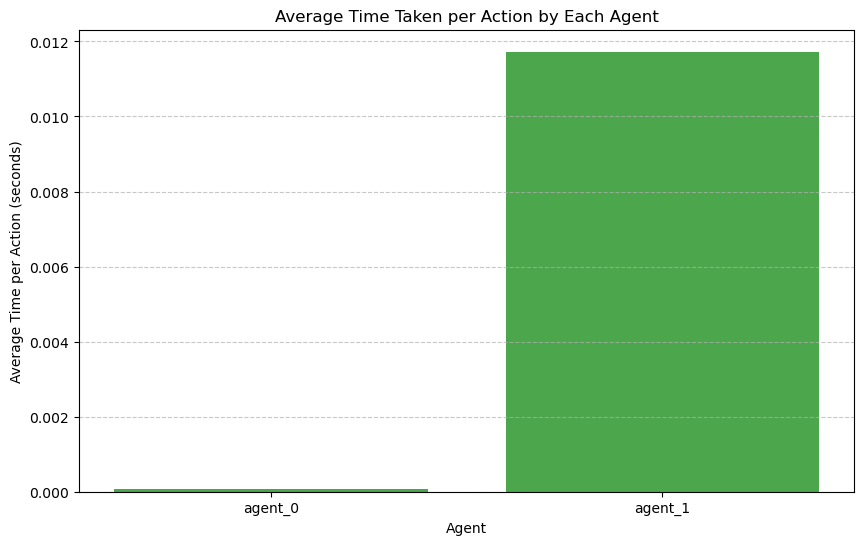

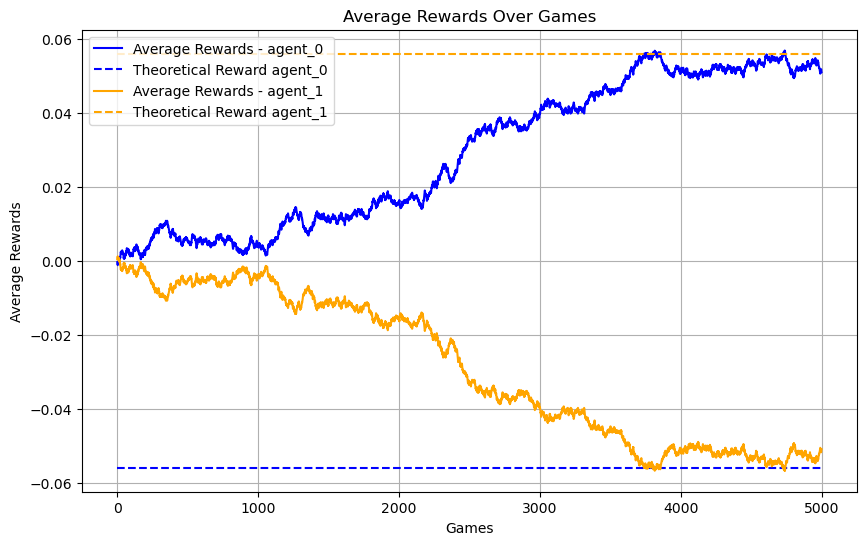

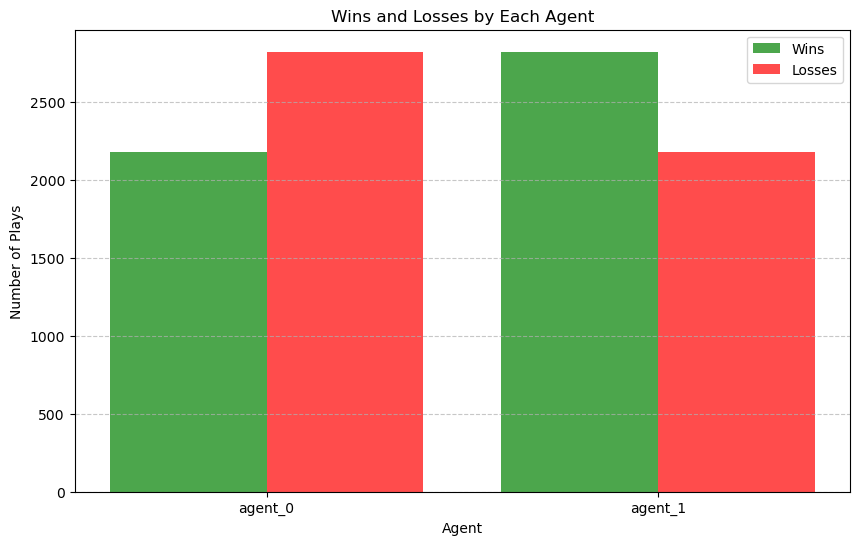

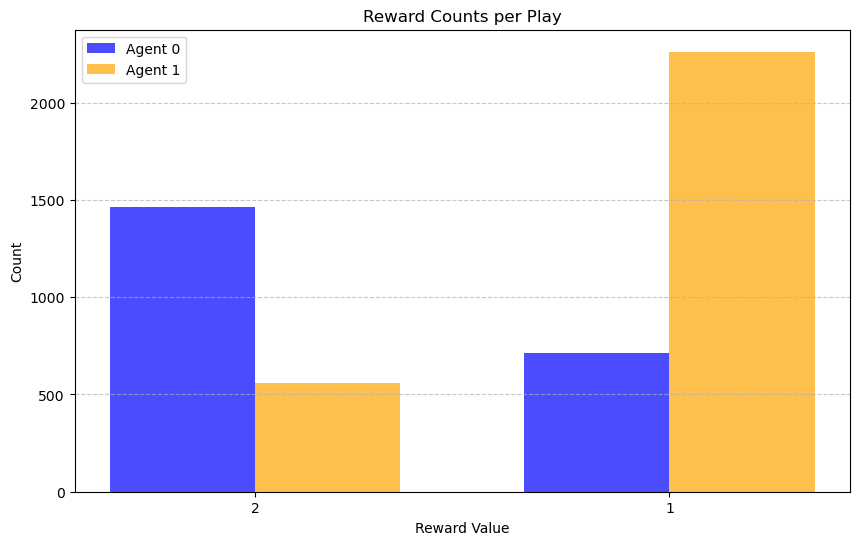

In [59]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, cfr_ismcts_agents, niter)
training_time_dict = {agent: training_time if agent == 'agent_0' else 0 for agent in game.agents}
plot_time_results(time_taken, training_time_dict=training_time_dict)
plot_rewards(game, niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)

In [60]:
#play_n_iterations_and_plot(game, cfr_ismcts_agents, niter=5000, iterations=10)

### Slow ISMCTS

In [61]:
# Reutilizamos uno de los agentes entrenados para CFR vs CFR
cfr_ismcts_agents_slow = {'agent_0': CounterFactualRegret(
    game=game,
    agent='agent_0',
    seed=42,
    track_frequency=1,
), 'agent_1': InformationSetMCTS(
    game=game,
    agent='agent_1',
    rollouts=5,
    simulations=30
)}

In [62]:
# Train the CFR agent and store the time
start_time = time.time()
cfr_ismcts_agents_slow['agent_0'].train(10000)
training_time = time.time() - start_time
print(f"Tiempo de entrenamiento del agente CFR: {training_time:.2f} segundos")


Tiempo de entrenamiento del agente CFR: 26.52 segundos


Iteration 100/5000
Iteration 200/5000
Iteration 300/5000
Iteration 400/5000
Iteration 500/5000
Iteration 600/5000
Iteration 700/5000
Iteration 800/5000
Iteration 900/5000
Iteration 1000/5000
Iteration 1100/5000
Iteration 1200/5000
Iteration 1300/5000
Iteration 1400/5000
Iteration 1500/5000
Iteration 1600/5000
Iteration 1700/5000
Iteration 1800/5000
Iteration 1900/5000
Iteration 2000/5000
Iteration 2100/5000
Iteration 2200/5000
Iteration 2300/5000
Iteration 2400/5000
Iteration 2500/5000
Iteration 2600/5000
Iteration 2700/5000
Iteration 2800/5000
Iteration 2900/5000
Iteration 3000/5000
Iteration 3100/5000
Iteration 3200/5000
Iteration 3300/5000
Iteration 3400/5000
Iteration 3500/5000
Iteration 3600/5000
Iteration 3700/5000
Iteration 3800/5000
Iteration 3900/5000
Iteration 4000/5000
Iteration 4100/5000
Iteration 4200/5000
Iteration 4300/5000
Iteration 4400/5000
Iteration 4500/5000
Iteration 4600/5000
Iteration 4700/5000
Iteration 4800/5000
Iteration 4900/5000
Iteration 5000/5000
Average r

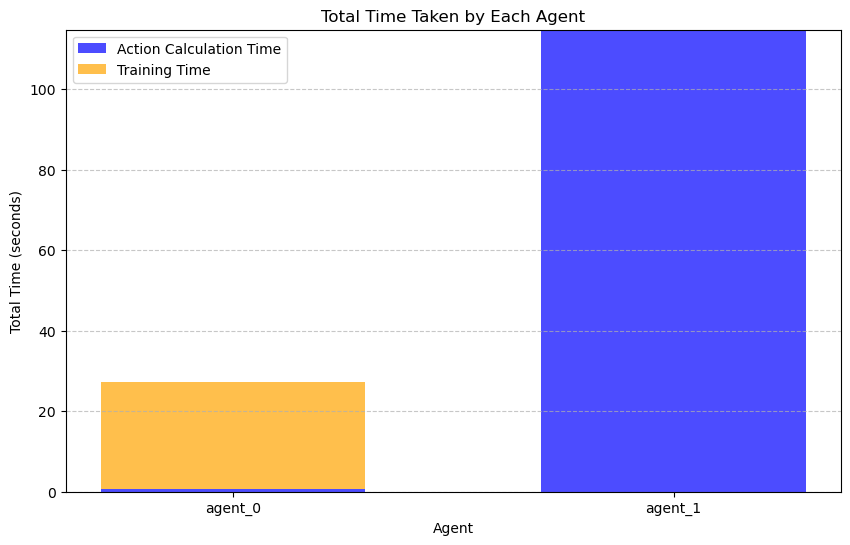

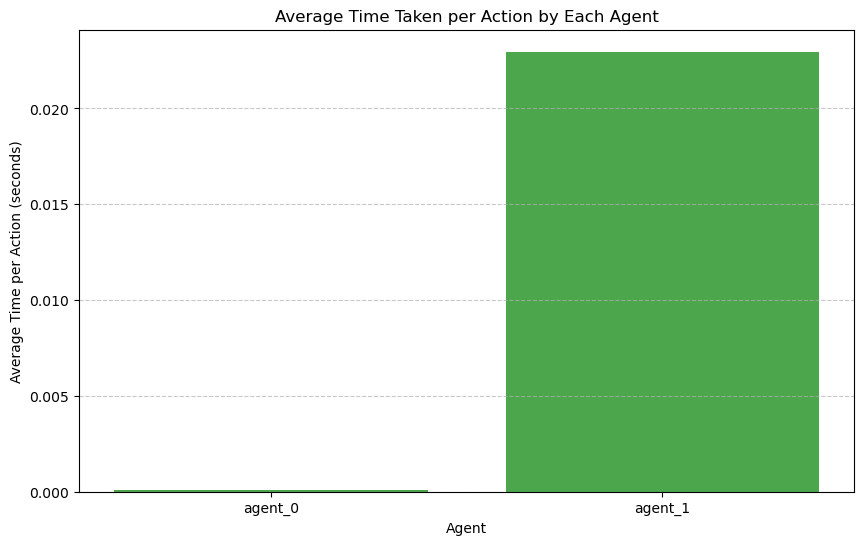

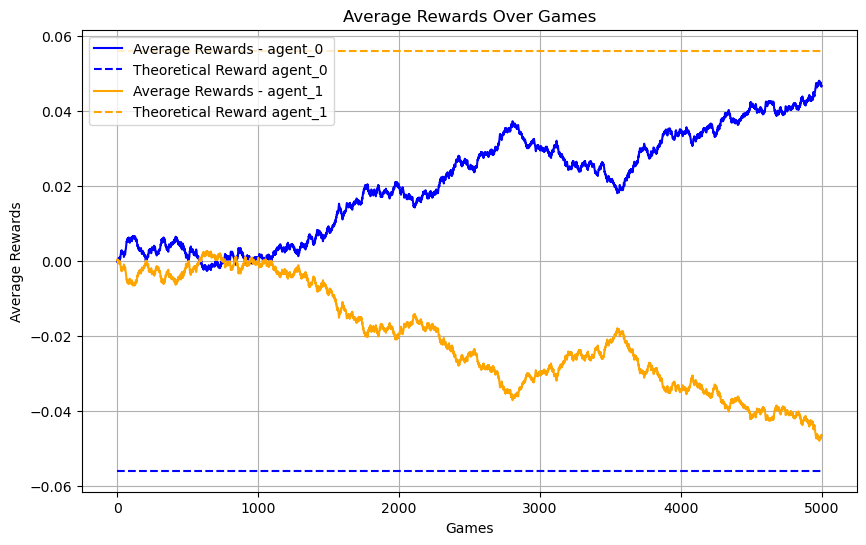

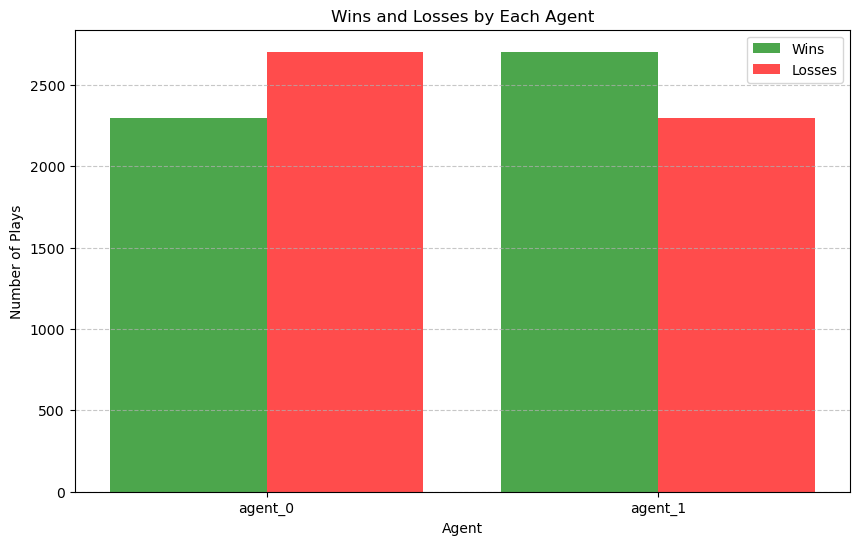

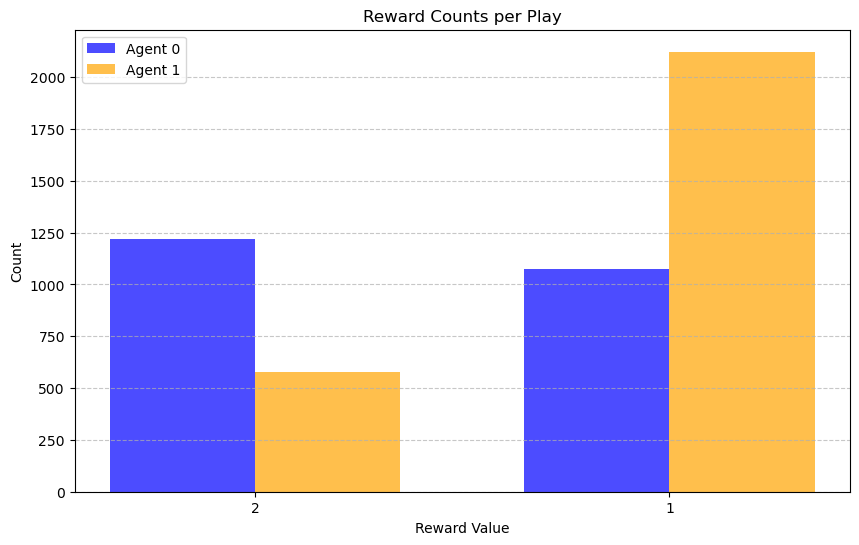

In [63]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, cfr_ismcts_agents_slow, niter)
training_time_for_agents = {'agent_0': training_time, 'agent_1': 0}  # Only agent_0 (CFR) has training time
plot_time_results(time_taken, training_time_dict=training_time_for_agents)
plot_rewards(game, niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)

In [64]:
#play_n_iterations_and_plot(game, cfr_ismcts_agents_slow, niter=5000, iterations=10)

## ISMCTS vs CFR

In [ ]:
# Reutilizamos uno de los agentes entrenados para CFR vs CFR
ismcts_cfr_agents = { 
'agent_0': InformationSetMCTS(
        game=game,
        agent='agent_0',
        rollouts=2,
        simulations=10
    ),
    'agent_1': CounterFactualRegret(
    game=game,
    agent='agent_1',
    seed=42,
    track_frequency=1,
)}

In [ ]:
# Train the CFR agent and store the time
start_time = time.time()
ismcts_cfr_agents['agent_1'].train(10000)
training_time = time.time() - start_time
print(f"Tiempo de entrenamiento del agente CFR: {training_time:.2f} segundos")


In [ ]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, ismcts_cfr_agents, niter)
plot_time_results(time_taken, training_time=training_time)
plot_rewards(game, niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)

In [ ]:
play_n_iterations_and_plot(game, ismcts_cfr_agents, niter=5000, iterations=10)

## ISMCTS vs ISMCTS

In [ ]:
agent_classes = [InformationSetMCTS, InformationSetMCTS]
ismcts_agents = {}
game.reset()
for i, agent in enumerate(game.agents):
    ismcts_agents[agent] = agent_classes[i](
        game=game, 
        agent=agent,
        rollouts=2,
        simulations=10 
    )

In [ ]:
niter = 5000  # Number of iterations for each play
cum_rewards, time_taken, winners = play(game, ismcts_cfr_agents, niter)
training_time_dict = {agent: 0 for agent in game.agents} # No training time for ISMCTS agents
plot_time_results(time_taken, training_time_dict=training_time_dict)
plot_rewards(game, niter, cum_rewards)
plot_winners(game, niter, cum_rewards, winners)